Group Project Proposal

Introduction:
We are using data on the top 500 tennis players. We will try to predict a player's prize money based on variables such as rank, number of seasons, height, and number of titles. 
The dataset we will be using is "Player Stats for Top 500 Players" from https://www.ultimatetennisstatistics.com/. 

In [77]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

In [78]:

player_stats<-read_csv("player_stats.csv")
player_stats


Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_character(),
  X1 = col_double(),
  `Turned Pro` = col_double(),
  Seasons = col_double(),
  Titles = col_double(),
  `Best Season` = col_double(),
  Retired = col_double(),
  Masters = col_double(),
  `Grand Slams` = col_double(),
  `Davis Cups` = col_double(),
  `Team Cups` = col_double(),
  Olympics = col_double(),
  `Weeks at No. 1` = col_double(),
  `Tour Finals` = col_double()
)

See spec(...) for full column specifications.



X1,Age,Country,Plays,Wikipedia,Current Rank,Best Rank,Name,Backhand,Prize Money,⋯,Facebook,Twitter,Nicknames,Grand Slams,Davis Cups,Web Site,Team Cups,Olympics,Weeks at No. 1,Tour Finals
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,26 (25-04-1993),Brazil,Right-handed,Wikipedia,378 (97),363 (04-11-2019),Oscar Jose Gutierrez,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,18 (22-12-2001),United Kingdom,Left-handed,Wikipedia,326 (119),316 (14-10-2019),Jack Draper,Two-handed,"$59,040",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,32 (03-11-1987),Slovakia,Right-handed,Wikipedia,178 (280),44 (14-01-2013),Lukas Lacko,Two-handed,"US$3,261,567",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
497,23 (14-03-1996),Netherlands,Left-handed,Wikipedia,495 (60),342 (05-08-2019),Gijs Brouwer,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
498,24 (17-05-1995),Ukraine,NA,Wikipedia,419 (81),419 (20-01-2020),Vladyslav Orlov,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
499,22 (26-03-1997),Tunisia,Left-handed,Wikipedia,451 (69),408 (24-12-2018),Aziz Dougaz,Two-handed,"$61,984",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [79]:
colnames(player_stats) <- make.names(colnames(player_stats))

#removing useless characters in 
player_stats$Prize.Money<-gsub("\\$","",as.character(player_stats$Prize.Money))
player_stats$Prize.Money<-gsub("US","",as.character(player_stats$Prize.Money))
player_stats$Prize.Money<-gsub("\\$ ","",as.character(player_stats$Prize.Money))
player_stats$Prize.Money<-gsub(",","",as.character(player_stats$Prize.Money))
player_stats$Prize.Money<-gsub(" .*","",as.character(player_stats$Prize.Money))
player_stats$Current.Rank<-gsub("\\(","",as.character(player_stats$Current.Rank))
player_stats$Current.Rank<-gsub("\\)","",as.character(player_stats$Current.Rank))
player_stats$Current.Elo.Rank<-gsub("\\)","",as.character(player_stats$Current.Elo.Rank))
player_stats$Current.Elo.Rank<-gsub("\\(","",as.character(player_stats$Current.Elo.Rank))


player_stats_tidy <- player_stats%>%
    separate(
        col = Age,
        into = c("Age", "DOB"),
        sep = " ", 
    ) %>%
    separate(
        col = Best.Rank,
        into = c("Best.Rank", "Best.Rank.Date"),
        sep = " ", 
    ) %>%
    separate(
        col = Best.Elo.Rank,
        into = c("Best.Elo.Rank", "Best.Elo.Rank.Date"),
        sep = " ", 
    ) %>%
    separate(
        col = Peak.Elo.Rating,
        into = c("Peak.Elo.Rating", "Peak.Elo.Rating.Date"),
        sep = " ", 
    ) %>%
    separate(
        col = Current.Elo.Rank,
        into = c("Current.Elo.Rank", "Current.Elo.Rating"),
        sep = " ", 
    ) %>%
    separate(
        col = Current.Rank,
        into = c("Current.Rank", "Current.Points"),
        sep = " ", 
    )
player_stats_tidy$Prize.Money<-as.numeric(player_stats_tidy$Prize.Money)
player_stats_tidy$Best.Rank<-as.numeric(player_stats_tidy$Best.Rank)
player_stats_tidy$Best.Elo.Rank<-as.numeric(player_stats_tidy$Best.Elo.Rank)
player_stats_tidy$Peak.Elo.Rating<-as.numeric(player_stats_tidy$Peak.Elo.Rating)
player_stats_tidy$Current.Elo.Rank<-as.numeric(player_stats_tidy$Current.Elo.Rank)
player_stats_tidy$Current.Elo.Rating<-as.numeric(player_stats_tidy$Current.Elo.Rating)
player_stats_tidy$Current.Rank<-as.numeric(player_stats_tidy$Current.Rank)
player_stats_tidy$Current.Points<-as.numeric(player_stats_tidy$Current.Points)
player_stats_tidy$Seasons<-as.numeric(player_stats_tidy$Seasons)
player_stats_tidy <- player_stats_tidy[complete.cases(player_stats_tidy[, "Prize.Money"]),] # Omit NAs in Prize.Money
  
set.seed(2022) 
player_stats_tidy_split <- initial_split(player_stats_tidy, prop = 0.75, strata = Prize.Money)
player_stats_training <- training(player_stats_tidy_split)
player_stats_testing <- testing(player_stats_tidy_split)

#view<- player_stats_tidy%>%
#    select(Prize.Money)
#head(view,275)

predictors = c("Current.Points", "Current.Rank", "Best.Rank", "Current.Elo.Rank", "Current.Elo.Rating", "Best.Elo.Rank", "Peak.Elo.Rating", "Seasons")
summary_table = player_stats_training %>%
                select(Prize.Money, all_of(predictors)) %>%
                summary()
summary_table

#sample_row = slice(player_stats_tidy, 16) %>%
# select(Prize.Money, Current.Points, Current.Rank, Current.Elo.Rank, Current.Elo.Rating, Best.Rank, Seasons, Best.Elo.Rank, Peak.Elo.Rating)
#sample_row

#sample_row2 = slice(player_stats_tidy, 1) %>%
# select(Prize.Money, Current.Points, Current.Rank, Current.Elo.Rank, Current.Elo.Rating, Best.Rank, Seasons, Best.Elo.Rank, Peak.Elo.Rating)
#sample_row2

player_stats_tidy


  Prize.Money       Current.Points    Current.Rank     Best.Rank    
 Min.   :     145   Min.   :  58.0   Min.   :  5.0   Min.   :  3.0  
 1st Qu.:  118195   1st Qu.: 116.0   1st Qu.:126.0   1st Qu.: 47.5  
 Median :  445928   Median : 207.0   Median :229.0   Median :135.0  
 Mean   : 1870828   Mean   : 426.2   Mean   :234.3   Mean   :152.0  
 3rd Qu.: 1828711   3rd Qu.: 429.0   3rd Qu.:337.0   3rd Qu.:218.5  
 Max.   :25889586   Max.   :5890.0   Max.   :499.0   Max.   :488.0  
                    NA's   :1        NA's   :1                      
 Current.Elo.Rank Current.Elo.Rating Best.Elo.Rank    Peak.Elo.Rating
 Min.   :  4.0    Min.   :1554       Min.   :  3.00   Min.   :1597   
 1st Qu.: 57.0    1st Qu.:1763       1st Qu.: 32.75   1st Qu.:1781   
 Median :104.5    Median :1822       Median : 71.00   Median :1872   
 Mean   :101.1    Mean   :1841       Mean   : 81.58   Mean   :1887   
 3rd Qu.:144.8    3rd Qu.:1914       3rd Qu.:123.25   3rd Qu.:1982   
 Max.   :191.0    Max.   :22

X1,Age,DOB,Country,Plays,Wikipedia,Current.Rank,Current.Points,Best.Rank,Best.Rank.Date,⋯,Facebook,Twitter,Nicknames,Grand.Slams,Davis.Cups,Web.Site,Team.Cups,Olympics,Weeks.at.No..1,Tour.Finals
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,18,(22-12-2001),United Kingdom,Left-handed,Wikipedia,326,119,316,(14-10-2019),⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,32,(03-11-1987),Slovakia,Right-handed,Wikipedia,178,280,44,(14-01-2013),⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,21,(29-05-1998),"Korea, Republic of",Right-handed,Wikipedia,236,199,130,(10-04-2017),⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
495,20,(13-04-1999),France,Right-handed,Wikipedia,382,95,380,(11-11-2019),⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
496,26,(03-09-1993),Austria,Right-handed,Wikipedia,5,5890,4,(06-11-2017),⋯,1.Dominic.Thiem,@ThiemDomi,Dominator,NA,NA,dominicthiem.tennis,NA,NA,NA,NA
499,22,(26-03-1997),Tunisia,Left-handed,Wikipedia,451,69,408,(24-12-2018),⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


Warning message:
“Removed 1 rows containing missing values (geom_point).”


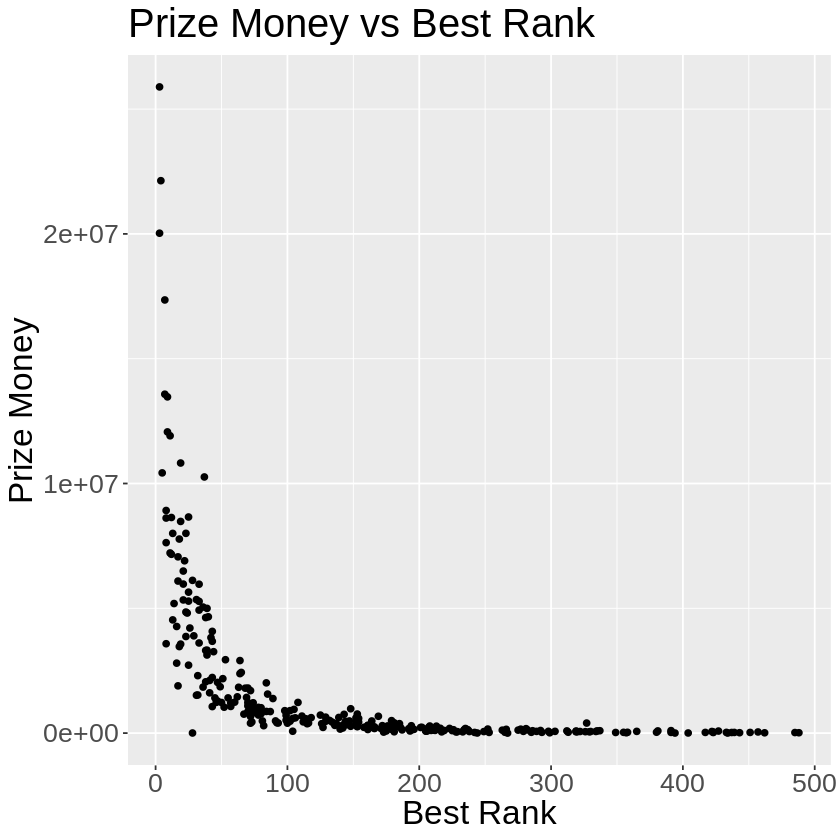

Warning message:
“Removed 1 rows containing missing values (geom_point).”


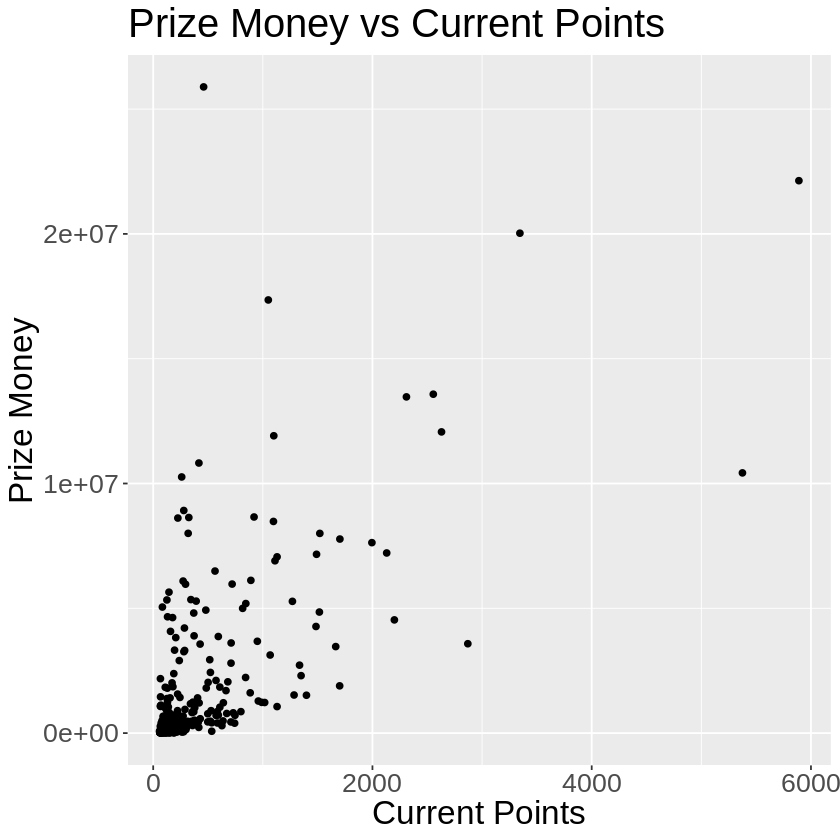

Warning message:
“Removed 180 rows containing missing values (geom_point).”


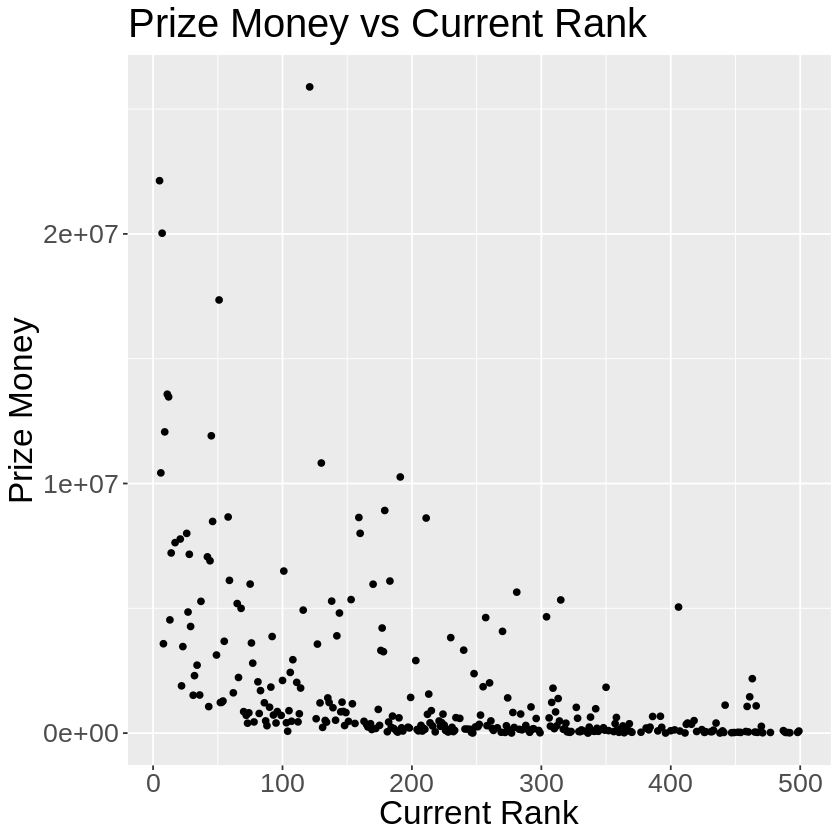

Warning message:
“Removed 180 rows containing missing values (geom_point).”


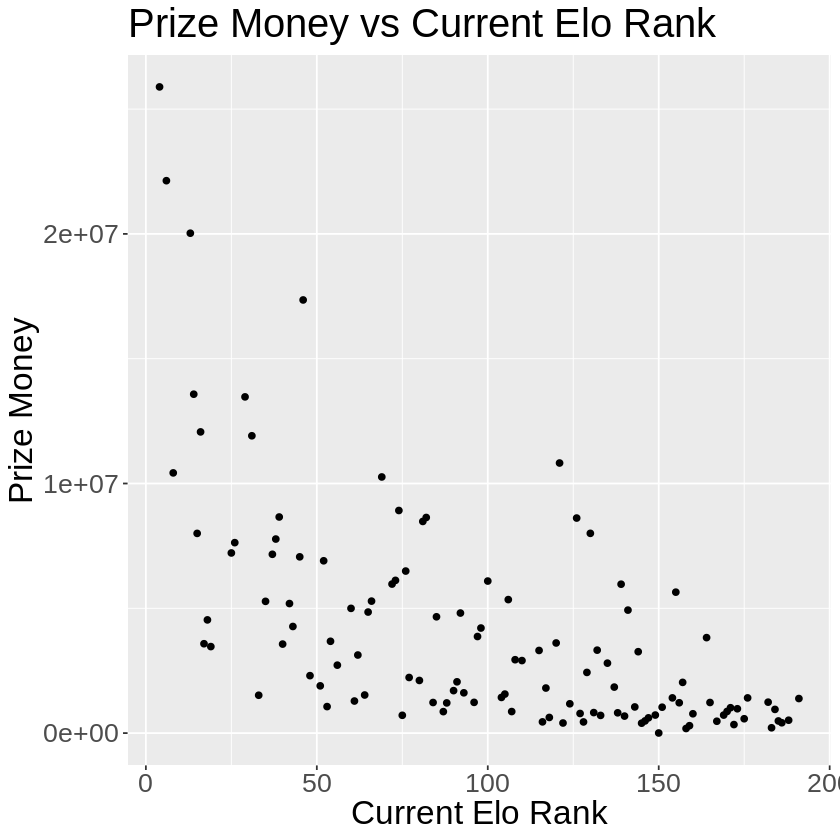

Warning message:
“Removed 138 rows containing missing values (geom_point).”


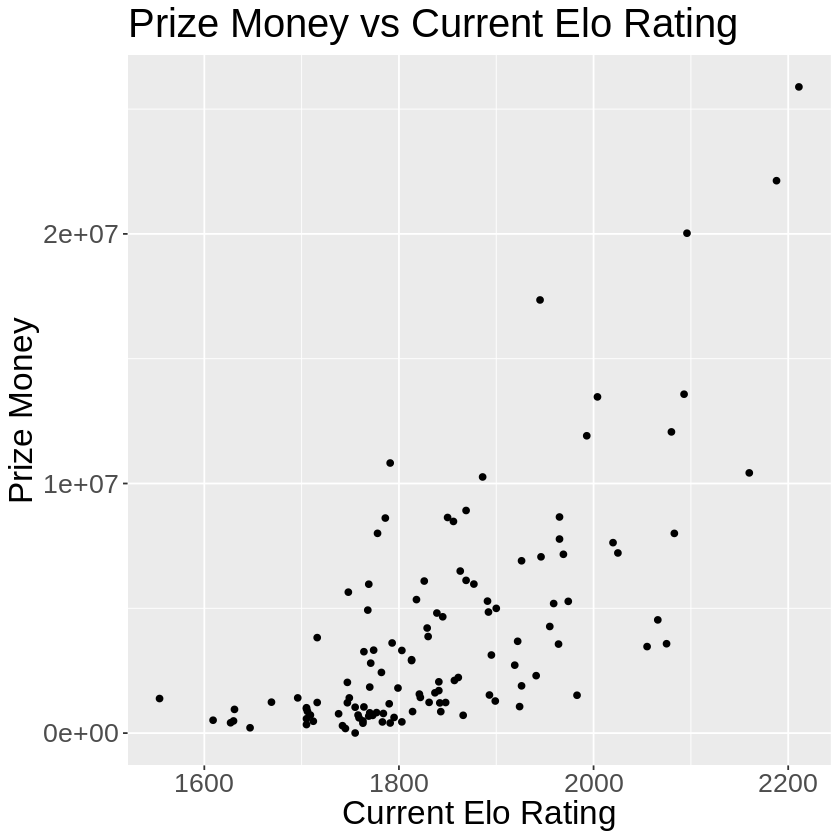

Warning message:
“Removed 138 rows containing missing values (geom_point).”


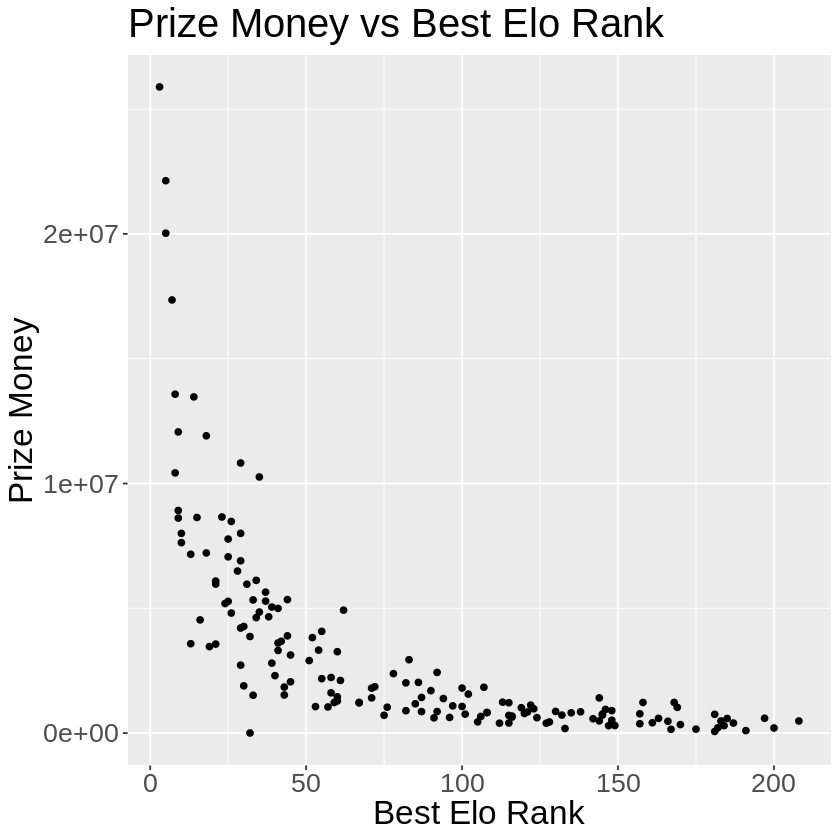

Warning message:
“Removed 38 rows containing missing values (geom_point).”


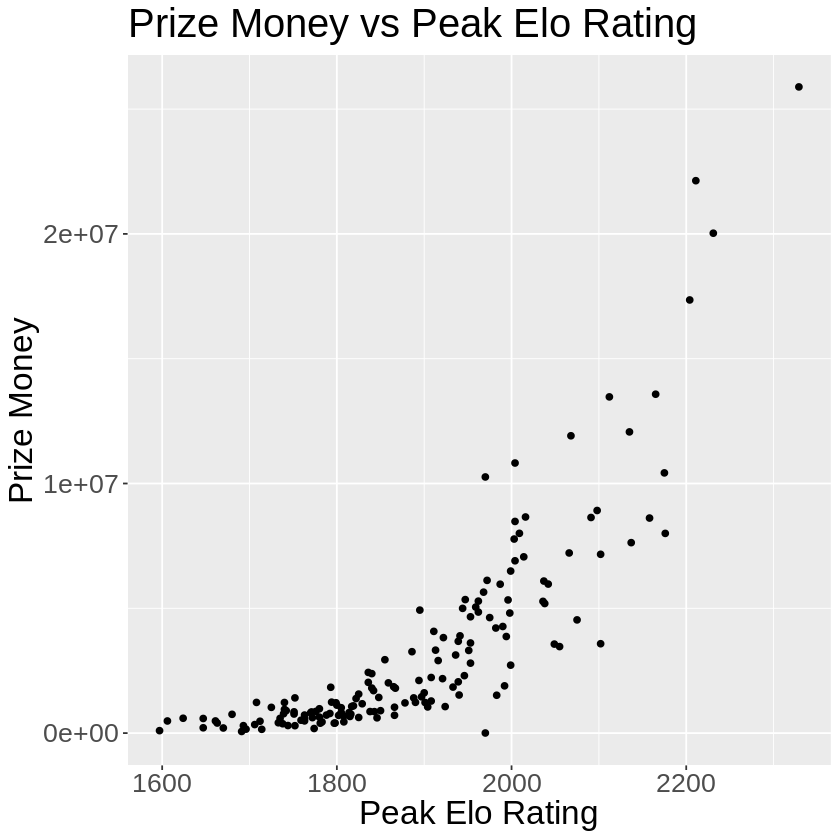

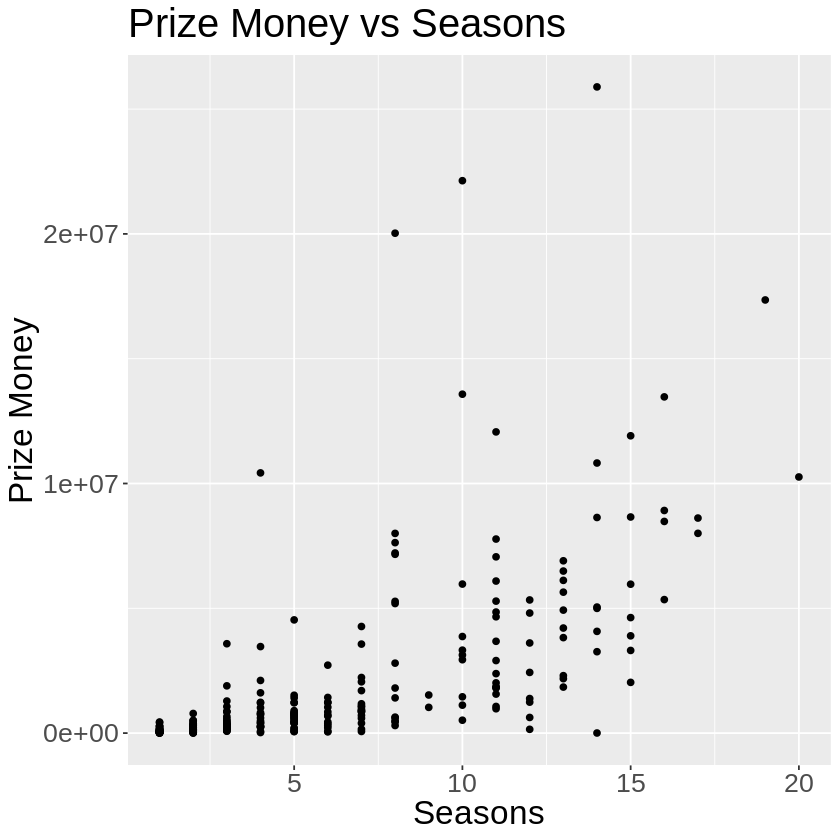

In [80]:
Best_Rank_plot<-player_stats_training%>%
    ggplot(aes(x=Best.Rank, y=Prize.Money))+
    geom_point() +
    labs(x="Best Rank", y ="Prize Money", title = "Prize Money vs Best Rank")+
    theme(text = element_text(size = 20))
Current_Points_plot<-player_stats_training%>%
    ggplot(aes(x=Current.Points, y=Prize.Money))+
    geom_point() +
    labs(x="Current Points", y ="Prize Money", title = "Prize Money vs Current Points")+
    theme(text = element_text(size = 20))
Current_Rank_plot<-player_stats_training%>%
    ggplot(aes(x=Current.Rank, y=Prize.Money))+
    geom_point() +
    labs(x="Current Rank", y ="Prize Money", title = "Prize Money vs Current Rank")+
    theme(text = element_text(size = 20))
Current_Elo_Rank_plot<-player_stats_training%>%
    ggplot(aes(x=Current.Elo.Rank, y=Prize.Money))+
    geom_point() +
    labs(x="Current Elo Rank", y ="Prize Money", title = "Prize Money vs Current Elo Rank")+
    theme(text = element_text(size = 20))
Current_Elo_Rating_plot<-player_stats_training%>%
    ggplot(aes(x=Current.Elo.Rating, y=Prize.Money))+
    geom_point() +
    labs(x="Current Elo Rating", y ="Prize Money", title = "Prize Money vs Current Elo Rating")+
    theme(text = element_text(size = 20))
Best_Elo_Rank_plot<-player_stats_training%>%
    ggplot(aes(x=Best.Elo.Rank, y=Prize.Money))+
    geom_point() +
    labs(x="Best Elo Rank", y ="Prize Money", title = "Prize Money vs Best Elo Rank")+
    theme(text = element_text(size = 20))
Peak_Elo_Rating_plot<-player_stats_training%>%
    ggplot(aes(x=Peak.Elo.Rating, y=Prize.Money))+
    geom_point() +
    labs(x="Peak Elo Rating", y ="Prize Money", title = "Prize Money vs Peak Elo Rating")+
    theme(text = element_text(size = 20))
Seasons_plot<-player_stats_training%>%
    ggplot(aes(x=Seasons, y=Prize.Money))+
    geom_point() +
    labs(x="Seasons", y ="Prize Money", title = "Prize Money vs Seasons")+
    theme(text = element_text(size = 20))
Best_Rank_plot
Current_Points_plot
Current_Rank_plot
Current_Elo_Rank_plot
Current_Elo_Rating_plot
Best_Elo_Rank_plot
Peak_Elo_Rating_plot
Seasons_plot

Methods:
We will use the columns "Current.Rank", "Current.Point", "Best.Rank", "Seasons", "Best.Elo.Rank", "Current.Elo.Rank", "Current.Elo.Rating" and "Peak.Elo.Rating" to predict a player's prize money. 
To conduct our analysis, we will first filter our data to remove any empty cells in our columns of interest.
We will then separate the data into the training and testing portions.
Then we will create a recipe and use k nearest neighbors to predict a player's prize money. 
We will visualize results by creating a plot of prize money against each of these variables seperately.

Expected outcomes:
We expect to see negetive relationship between prize money and ranks, and we expect to see positive relationship between prize money and other predictors.We also expect accurate predictions on prize money with these selected predictors.
These findings would provide a model to predict the prize money of tennis players based on their statisics so that they could make a better decision on their career.
This study could lead to further studys that predict the income of other sports players.